### Visualization Tools
- Spectrograms - Frequency over time `spec()`

- Oscillograms - waveform displays `oscillo()`

- Amplitude envelopes - loudness changes `env()`

### Frequency Analysis
- Fundamental Frequency - pitch detection `fund()`

- Dominant Frequency - most prominent frequency over time `dfreq()`



### Audio Quality Metrics
- Clipping Detection - Detects distortion from exceeding max amplitude: No clipping = good
- Dynamic Range - Difference between Loudest and quietest parts in loudest vs quietest:Quality:  >40 dB = excellent; <20 dB compressed
- Signal to noise ratio -  measures how clean the audio is: Quality: >40 dB = excellent; <20 dB compressed
- Harmonic to noise ratio - measures tonal clarity :Quality: > 20 dB = very clear; < 10 dB = noisy
- Frequency Response - analyzes energy distribution across frequency bands, checks for missing frequency ranges
- Silence Detection - finds excessive silence :Quality: < 5% = good; > 20% = problematic
-  Technical Specs - Bit depth: 16-bit = CD quality, 24-bit = better
Sample rate: 44.1 kHz = CD quality

### Conversion Mp3 -> WAV

In [15]:
# 2. CONVERTING MP3 TO WAV
# ============================================

# Step 1: Read MP3 file
# mp3_file <- readMP3("input.mp3")

# Step 2: Write as WAV file
# writeWave(mp3_file, "output.wav")


# tuneR Package Capabilities

The `tuneR` package provides many useful functions for audio analysis:

## Key Features:
1. **Reading/Writing Audio**: Support for WAV, MP3, and other formats
2. **Stereo/Mono Operations**: Convert between formats, extract channels
3. **Normalization & Filtering**: Adjust volume, apply filters
4. **Resampling**: Change sample rates
5. **Waveform Manipulation**: Cut, append, bind audio segments
6. **Pitch Detection**: Fundamental frequency (F0) estimation
7. **Audio Effects**: Fade in/out, silence removal
8. **Format Conversion**: Convert between different audio formats


# seewave Package Capabilities

The `seewave` package is a comprehensive toolkit for sound analysis and synthesis:

## Main Categories:

### 1. **Visualization**
- Spectrograms (2D and 3D)
- Oscillograms (waveforms)
- Frequency spectra
- Amplitude envelopes
- Time-frequency representations

### 2. **Frequency Analysis**
- Fundamental frequency (pitch) detection
- Dominant frequency extraction
- Spectrum analysis
- Frequency domain transformations
- Harmonic analysis

### 3. **Time-Domain Analysis**
- Amplitude envelope
- Zero-crossing rate
- Autocorrelation
- Cross-correlation
- Energy calculations

### 4. **Signal Processing**
- Filters (Butterworth, FIR)
- Resampling
- Windowing functions
- Signal smoothing
- Noise reduction

### 5. **Statistical Measures**
- Entropy calculations
- Resonance quality factor
- Spectral features
- Signal statistics

### 6. **Sound Synthesis**
- Generate synthetic sounds
- Additive synthesis
- Tonal models
- Create test signals


# Demonstration on test audio Sample

In [16]:
library(tuneR)
library(seewave)



In [17]:
test = readWave("Test Hum.wav")
#summary(test)


### Oscillogram (Wave Form)

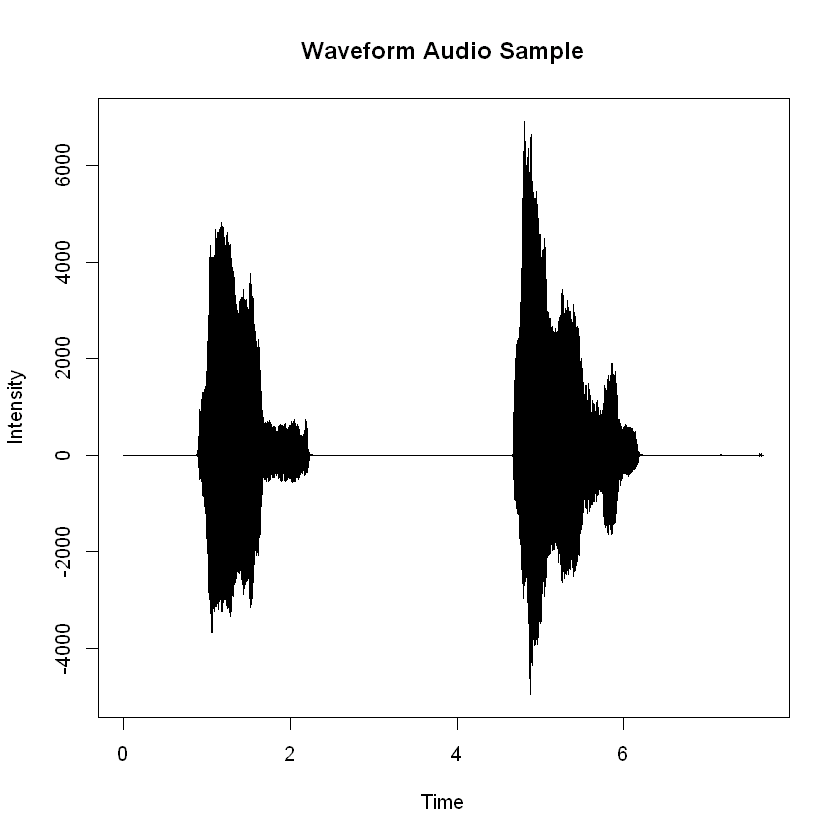

In [18]:
left = test@left


time = (1:length(test@left)) / test@samp.rate
plot(time, left, type = "l", main = "Waveform Audio Sample",
     xlab = "Time",
     ylab = "Intensity")

### Spectrogram

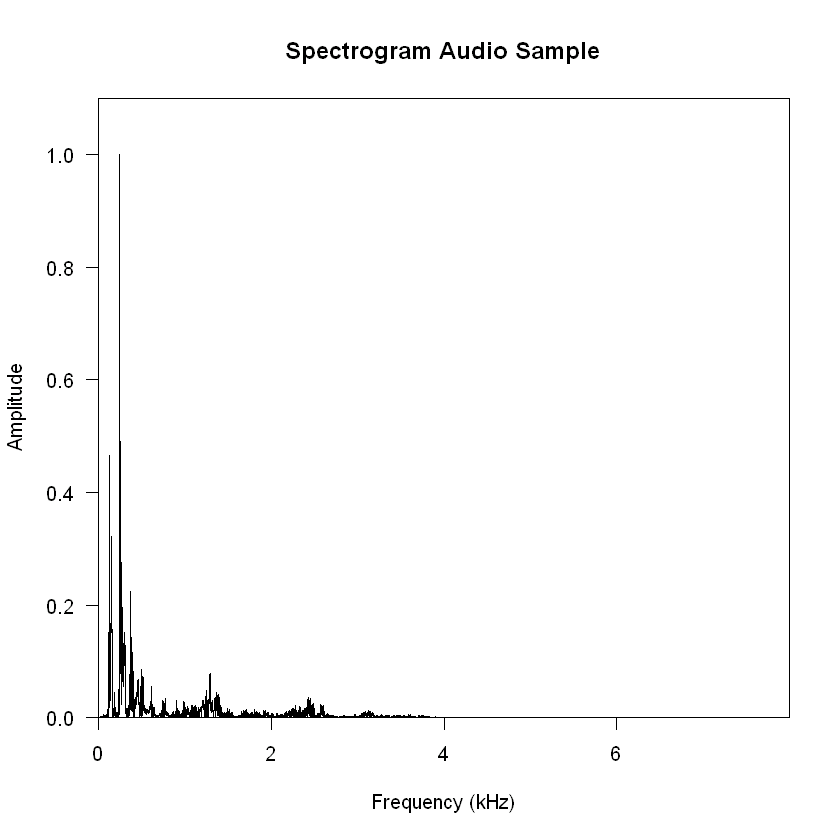

In [19]:

spec(test, f = test@samp.rate, yaxt = "s", main = "Spectrogram Audio Sample")
    

# Statistical Measures in Audio Analysis

Statistical measures help quantify and analyze audio signals numerically. seewave provides many statistical functions for characterizing audio properties.


In [20]:
# ============================================
# 1. CLIPPING DETECTION - Digital distortion
# ============================================

# Clipping occurs when signal exceeds maximum amplitude
# For 16-bit audio: max = 32767, min = -32768
signal <- test@left
max_possible <- ifelse(test@bit == 16, 32767, 
                       ifelse(test@bit == 8, 127, 2147483647))
min_possible <- ifelse(test@bit == 16, -32768, 
                       ifelse(test@bit == 8, -128, -2147483648))

# Check for clipping
clipped_samples <- sum(signal >= max_possible * 0.99 | signal <= min_possible * 0.99)
clipping_percentage <- (clipped_samples / length(signal)) * 100

print("Clipping Analysis:")
print(paste("  Maximum value:", max(signal)))
print(paste("  Minimum value:", min(signal)))
print(paste("  Theoretical max:", max_possible))
print(paste("  Clipped samples:", clipped_samples, "(", round(clipping_percentage, 2), "%)"))
print("  Quality:")
if (clipping_percentage == 0) {
  print("    ✅ No clipping detected - Good quality")
} else if (clipping_percentage < 0.1) {
  print("    ⚠️ Minor clipping - Acceptable")
} else {
  print("    ❌ Significant clipping - Poor quality")
}


[1] "Clipping Analysis:"
[1] "  Maximum value: 6916"
[1] "  Minimum value: -4961"
[1] "  Theoretical max: 32767"
[1] "  Clipped samples: 0 ( 0 %)"
[1] "  Quality:"
[1] "    ✅ No clipping detected - Good quality"


In [21]:
# ============================================
# 2. DYNAMIC RANGE - Difference between loudest and quietest
# ============================================

# Dynamic range = ratio of maximum to minimum RMS amplitude
# Higher = better quality (more expressive range)

# Calculate RMS in windows
window_size <- 2048
n_windows <- floor(length(signal) / window_size)
rms_values <- numeric(n_windows)

for (i in 1:n_windows) {
  start <- (i - 1) * window_size + 1
  end <- i * window_size
  window_signal <- signal[start:end]
  rms_values[i] <- sqrt(mean(window_signal^2))
}

# Remove zeros to avoid log issues
rms_values <- rms_values[rms_values > 0]

max_rms <- max(rms_values)
min_rms <- min(rms_values[rms_values > 0])
dynamic_range_db <- 20 * log10(max_rms / min_rms)

print("Dynamic Range Analysis:")
print(paste("  Max RMS:", round(max_rms, 2)))
print(paste("  Min RMS:", round(min_rms, 2)))
print(paste("  Dynamic Range:", round(dynamic_range_db, 2), "dB"))
print("  Quality:")
if (dynamic_range_db > 40) {
  print("    ✅ Excellent dynamic range")
} else if (dynamic_range_db > 20) {
  print("    ✅ Good dynamic range")
} else {
  print("    ⚠️ Limited dynamic range (compressed)")
}


[1] "Dynamic Range Analysis:"
[1] "  Max RMS: 2121.3"
[1] "  Min RMS: 0.07"
[1] "  Dynamic Range: 89.65 dB"
[1] "  Quality:"
[1] "    ✅ Excellent dynamic range"


In [22]:
# ============================================
# 3. SIGNAL-TO-NOISE RATIO (SNR) Estimation
# ============================================

# Estimate SNR by comparing signal energy to noise floor
# Assumes quieter segments contain mostly noise

# Find quiet segments (bottom 10% of RMS values)
rms_sorted <- sort(rms_values)
noise_floor_idx <- floor(length(rms_sorted) * 0.1)
noise_floor_rms <- mean(rms_sorted[1:noise_floor_idx])

# Signal power (overall RMS)
signal_rms <- sqrt(mean(signal^2))

# Estimate SNR
if (noise_floor_rms > 0 && signal_rms > noise_floor_rms) {
  snr_estimate <- 20 * log10(signal_rms / noise_floor_rms)
} else {
  snr_estimate <- NA
}

print("Signal-to-Noise Ratio Estimation:")
print(paste("  Signal RMS:", round(signal_rms, 2)))
print(paste("  Noise Floor RMS:", round(noise_floor_rms, 2)))
if (!is.na(snr_estimate)) {
  print(paste("  Estimated SNR:", round(snr_estimate, 2), "dB"))
  print("  Quality:")
  if (snr_estimate > 40) {
    print("    ✅ Excellent SNR (very clean)")
  } else if (snr_estimate > 20) {
    print("    ✅ Good SNR (acceptable)")
  } else {
    print("    ⚠️ Low SNR (noisy recording)")
  }
} else {
  print("  Could not estimate SNR")
}


[1] "Signal-to-Noise Ratio Estimation:"
[1] "  Signal RMS: 723.1"
[1] "  Noise Floor RMS: 0.07"
[1] "  Estimated SNR: 80.3 dB"
[1] "  Quality:"
[1] "    ✅ Excellent SNR (very clean)"


In [23]:
# ============================================
# 4. HARMONIC-TO-NOISE RATIO (HNR) - Tonal clarity
# ============================================

# Convert audio to numeric vector if using Wave object
audio <- test@left  # or test@right if stereo
fs <- test@samp.rate

# Compute FFT
n <- length(audio)
spec <- abs(fft(audio))^2
freqs <- (0:(n-1)) * fs / n

# Focus on frequencies of interest (50-500 Hz)
freq_idx <- which(freqs >= 50 & freqs <= 500)
spec_focus <- spec[freq_idx]

# Estimate harmonic energy (peak) vs noise energy (rest)
harmonic_energy <- max(spec_focus)
noise_energy <- mean(spec_focus[-which.max(spec_focus)])

# Compute HNR in dB
hnr_val <- 10 * log10(harmonic_energy / noise_energy)

print("Harmonic-to-Noise Ratio:")
print(paste("  HNR:", round(hnr_val, 2), "dB"))
print("  Quality (for tonal sounds):")
if (hnr_val > 20) {
  print("    ✅ Excellent tonal quality (very clear)")
} else if (hnr_val > 15) {
  print("    ✅ Good tonal quality (clear)")
} else if (hnr_val > 10) {
  print("    ⚠️ Moderate quality (somewhat clear)")
} else {
  print("    ❌ Poor tonal quality (very noisy)")
}



[1] "Harmonic-to-Noise Ratio:"
[1] "  HNR: 21.27 dB"
[1] "  Quality (for tonal sounds):"
[1] "    ✅ Excellent tonal quality (very clear)"


In [24]:
# ============================================
# 5. FREQUENCY RESPONSE - Frequency content quality
# ============================================

# Check if frequency content is appropriate for audio type
# Analyze energy distribution across frequency bands

signal <- test@left
fs <- test@samp.rate
n <- length(signal)
fft_result <- fft(signal)
magnitude <- Mod(fft_result[1:(n/2)])
freq <- (0:(n/2 - 1)) * fs / n

# Define frequency bands
low_freq <- freq <= 300      # Low frequencies (bass)
mid_freq <- freq > 300 & freq <= 3000  # Mid frequencies (speech)
high_freq <- freq > 3000     # High frequencies (detail)

low_energy <- sum(magnitude[low_freq])
mid_energy <- sum(magnitude[mid_freq])
high_energy <- sum(magnitude[high_freq])
total_energy <- sum(magnitude)

low_percent <- (low_energy / total_energy) * 100
mid_percent <- (mid_energy / total_energy) * 100
high_percent <- (high_energy / total_energy) * 100

print("Frequency Response Analysis:")
print(paste("  Low (0-300 Hz):", round(low_percent, 1), "%"))
print(paste("  Mid (300-3000 Hz):", round(mid_percent, 1), "%"))
print(paste("  High (>3000 Hz):", round(high_percent, 1), "%"))
print("  Interpretation:")
if (mid_percent > 40) {
  print("    ✅ Good mid-frequency content (important for speech)")
}
if (high_percent < 5 && fs >= 16000) {
  print("    ⚠️ Limited high-frequency content (possible filtering)")
}


[1] "Frequency Response Analysis:"
[1] "  Low (0-300 Hz): 39.4 %"
[1] "  Mid (300-3000 Hz): 57 %"
[1] "  High (>3000 Hz): 3.6 %"
[1] "  Interpretation:"
[1] "    ✅ Good mid-frequency content (important for speech)"
[1] "    ⚠️ Limited high-frequency content (possible filtering)"


In [25]:
# ============================================
# 6. SILENCE DETECTION - Dead air or unwanted silence
# ============================================

# Detect extended periods of silence (low energy)
silence_threshold <- 0.01 * max(abs(signal))  # 1% of max amplitude
window_size <- 2048
n_windows <- floor(length(signal) / window_size)
energy_per_window <- numeric(n_windows)

for (i in 1:n_windows) {
  start <- (i - 1) * window_size + 1
  end <- i * window_size
  window_signal <- signal[start:end]
  energy_per_window[i] <- sqrt(mean(window_signal^2))
}

silent_windows <- sum(energy_per_window < silence_threshold)
silence_percentage <- (silent_windows / n_windows) * 100
silence_duration <- (silent_windows * window_size) / fs

print("Silence Detection:")
print(paste("  Silent windows:", silent_windows, "/", n_windows))
print(paste("  Silence duration:", round(silence_duration, 2), "seconds"))
print(paste("  Percentage:", round(silence_percentage, 1), "%"))
print("  Quality:")
if (silence_percentage < 5) {
  print("    ✅ Minimal silence (good content)")
} else if (silence_percentage < 20) {
  print("    ⚠️ Some silence detected (acceptable)")
} else {
  print("    ❌ Excessive silence (check recording)")
}


[1] "Silence Detection:"
[1] "  Silent windows: 37 / 60"
[1] "  Silence duration: 4.74 seconds"
[1] "  Percentage: 61.7 %"
[1] "  Quality:"
[1] "    ❌ Excessive silence (check recording)"


In [26]:
# ============================================
# 7. BIT DEPTH & SAMPLE RATE QUALITY
# ============================================

# Check technical specifications
bit_depth <- test@bit
sample_rate <- test@samp.rate
duration <- length(test@left) / test@samp.rate

print("Technical Specifications:")
print(paste("  Bit Depth:", bit_depth, "bits"))
print(paste("  Sample Rate:", sample_rate, "Hz"))
print(paste("  Duration:", round(duration, 2), "seconds"))
print(paste("  Channels:", ifelse(test@stereo, "Stereo", "Mono")))

print("  Quality Assessment:")
# Bit depth
if (bit_depth >= 24) {
  print("    ✅ Excellent bit depth (24-bit)")
} else if (bit_depth >= 16) {
  print("    ✅ Good bit depth (16-bit - CD quality)")
} else {
  print("    ⚠️ Low bit depth (< 16-bit - limited dynamic range)")
}

# Sample rate
if (sample_rate >= 44100) {
  print("    ✅ Excellent sample rate (CD quality or better)")
} else if (sample_rate >= 16000) {
  print("    ✅ Adequate sample rate (good for speech)")
} else {
  print("    ⚠️ Low sample rate (< 16kHz - limited frequency range)")
}


[1] "Technical Specifications:"
[1] "  Bit Depth: 16 bits"
[1] "  Sample Rate: 16000 Hz"
[1] "  Duration: 7.68 seconds"
[1] "  Channels: Mono"
[1] "  Quality Assessment:"
[1] "    ✅ Good bit depth (16-bit - CD quality)"
[1] "    ✅ Adequate sample rate (good for speech)"
